# Kernel Density Estimation

In [1]:
import matplotlib.pyplot as plt
import math
import numpy as np
import scipy as sp
import qmcpy as qp
from scipy import stats
from simple_colors import *
from copy import deepcopy
import sympy as sy

### Some LaTeX macros (hidden in math mode)
$
\newcommand{\vt}{\boldsymbol{t}}
\newcommand{\vx}{\boldsymbol{x}}
\newcommand{\vX}{\boldsymbol{X}}
\newcommand{\cf}{\mathcal{F}}
\newcommand{\cu}{\mathcal{U}}
\newcommand{\dif}{\mathrm{d}}
\newcommand{\Ex}{\mathbb{E}}
\DeclareMathOperator{\disc}{disc}
\newcommand{\norm}[2][{}]{{\left \lVert #2 \right \rVert}_{#1}}
$

In [2]:
x = sy.symbols('x')
f = sy.Function('f')
def f(x):
    if x == 0:
        return 0
    else:
        return x + 1

In [4]:
f(sy.pi)

1 + pi

In [9]:
y = sy.symbols('y')
sy.pprint(y+sy.pi)
f(y)

y + π


y + 1

In [80]:
sy.Matrix.vstack(sy.eye(1),sy.zeros(r,1))

Matrix([
[1],
[0]])

## Isotropic Kernels

In [40]:
h  = sy.symbols('h',positive =  True)
t, u, v, w, x, y, z  = sy.symbols('t u v w x y z',real =  True)

### Hermite functions

#### Constructing a density kernel whose integral is one and whose integral against low order polynomials vanishes

Matrix([[1]])
ktilde = sqrt(2)*exp(-y**2/2)/(2*sqrt(pi))


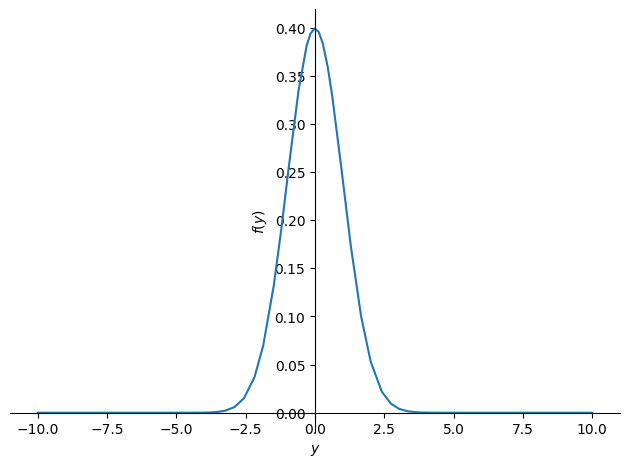

In [84]:
def sy_hermite_kernel(y,r = 1):
    '''
    r = number of terms in our kernel
    '''
    wt = sy.exp(-y*y/2) #normalizing weight for Hermite functions
    k = sy.zeros(r,1) #initialize a vector of bases that make up the kernel
    intk = sy.zeros(r,r) #initialize a matrix of integrals of the bases with respect to even degree polynomials
    for ii in range(r):
        k[ii] = sy.hermite(2*ii,y)*wt #form the bases
        for jj in range(r):
            intk[ii,jj] = sy.integrate(k[ii]*(y**(2*jj)),(y,-sy.oo,sy.oo)) #evaluate the integrals
    tot_int = sy.Matrix.vstack(sy.eye(1),sy.zeros(r-1,1)) #the kernel integrated against y, y^2, ... y^r should be zero
    print(tot_int)
#    tot_int[0] = 1 #the integral of the kernel should be one
    coef = sy.Matrix(list(sy.linsolve((intk,tot_int)))) #solve the system of equations for the coefficients of the bases
#    print(coef) #solve the system of equations for the coefficients of the bases
#    coef = sy.Matrix(list(coef)) #solve the system of equations for the coefficients of the bases
#    print('coef =',coef)
    return coef.dot(k)
ktilde = sy_hermite_kernel(y,1)
print('ktilde =',ktilde)
sy.plot(ktilde)

coef = [(sqrt(2)/(2*sqrt(pi)),)]
ktilde = sqrt(2)*exp(-y**2/2)/(2*sqrt(pi))


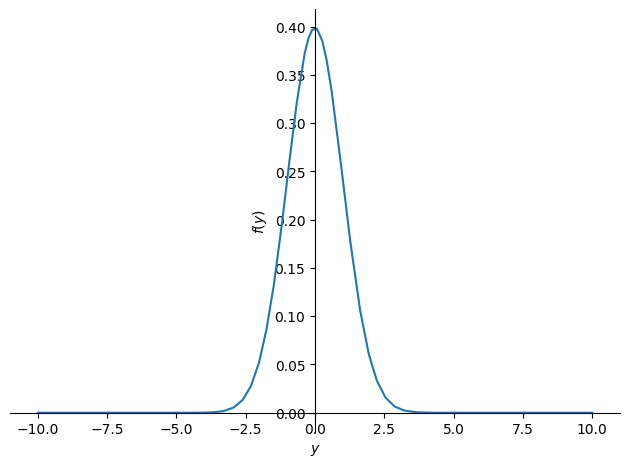

In [51]:
wt = sy.exp(-y*y/2) #normalizing weight for Hermite functions
r = 1 #number of terms in our kernel
k = sy.zeros(r,1) #initialize a vector of bases that make up the kernel
intk = sy.zeros(r,r) #initialize a matrix of integrals of the bases with respect to even degree polynomials
for ii in range(r):
    k[ii] = sy.hermite(2*ii,y)*wt #form the bases
    for jj in range(r):
        intk[ii,jj] = sy.integrate(k[ii]*(y**(2*jj)),(y,-sy.oo,sy.oo)) #evaluate the integrals
tot_int = sy.zeros(r,1) #the kernel integrated against y, y^2, ... y^r should be zero
tot_int[0] = 1 #the integral of the kernel should be one
coef = list(sy.linsolve((intk,tot_int))) #solve the system of equations for the coefficients of the bases
print('coef =',coef)
ktilde = k.dot(coef)
print('ktilde =',ktilde)
sy.plot(ktilde)

In [16]:
ktilde = sy.exp(-y**2/2)/sy.sqrt(2*sy.pi) #density kernel
KYtilde = sy.exp(-y**2/2/(sy.sqrt(2*sy.pi))) #reproducing kernel
integone = sy.simplify(sy.integrate(ktilde * KYtilde.subs(y,(y-z)*h),(y,-sy.oo,sy.oo)))
#print(integone)
kqual = sy.simplify(KYtilde.subs(y,0) - 2*sy.integrate(ktilde * KYtilde.subs(y,y*h),(y,-sy.oo,sy.oo)) \
    + sy.integrate(integone * ktilde.subs(y,z),(z,-sy.oo,sy.oo)))
print(kqual)

1 - 2/sqrt(sqrt(2)*h**2/(2*sqrt(pi)) + 1) + sqrt(2)*pi**(1/4)/(sqrt(1 - 2*polar_lift(-1/2 + sqrt(pi)/(sqrt(2)*h**2 + 2*sqrt(pi))))*sqrt(sqrt(2)*h**2 + 2*sqrt(pi)))


## Generate some $x$ points

In [5]:
d = 1
n = 2**12
iidpts = qp.IIDStdUniform(d).gen_samples(n)
print("iid pts",iidpts)
sobpts = qp.Sobol(d).gen_samples(n)
print("sobol pts",sobpts)

iid pts [[0.96977204]
 [0.92150004]
 [0.97579372]
 ...
 [0.42501678]
 [0.11245829]
 [0.91115832]]
sobol pts [[0.10664934]
 [0.58567043]
 [0.4576133 ]
 ...
 [0.74166487]
 [0.36361538]
 [0.82700756]]


## Generate some $y=f(x)$ points

In [6]:
def testfun(x):
  # return np.exp(-5*x)*np.sin(2*np.pi*x)
    return sp.stats.norm.ppf(x)

In [7]:
yiid = testfun(iidpts)
ysob = testfun(sobpts)

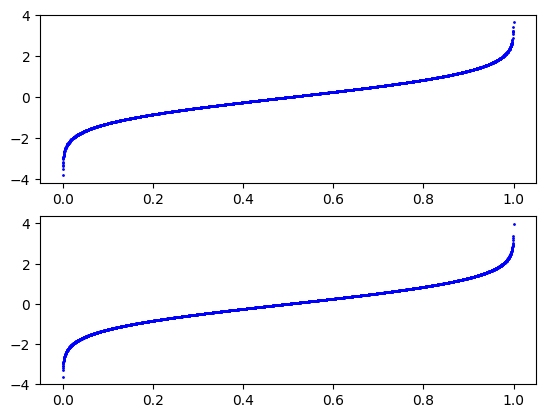

In [8]:
fig,ax = plt.subplots(2)
ax[0].plot(iidpts, yiid, 'b.', markersize = 2)
ax[1].plot(sobpts, ysob, 'b.', markersize = 2);

## Compute the kernel density estimator

In [51]:
def kde(y,x):
    density_estimate = stats.gaussian_kde(y.T)
    kdevalues = density_estimate(x)
    return kdevalues, density_estimate    
    #return density_estimate

In [52]:
right = 3
step = 0.01
xvalues = np.arange(-right,right,step)
small_n = int(np.sqrt(n))

In [55]:
kdeiidsmall, trash = kde(yiid[:small_n],xvalues)
print('small_n',small_n)
print('kdeiidsmall',kdeiidsmall[:10])
kdeiid, trash = kde(yiid,xvalues)
kdesobsmall, trash = kde(ysob[:small_n],xvalues)
kdesob, trash = kde(ysob,xvalues)

small_n 64
kdeiidsmall [0.00182468 0.00192969 0.00203995 0.00215567 0.00227707 0.00240438
 0.00253783 0.00267765 0.00282409 0.0029774 ]


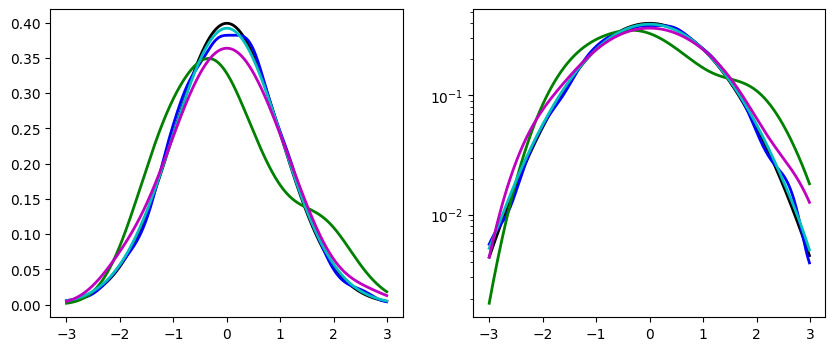

In [77]:
fig,ax = plt.subplots(1,ncols=2,figsize = (10,4))
for ii in range(2):
    ax[ii].plot(xvalues, stats.norm.pdf(xvalues), 'k-', linewidth = 2);
    ax[ii].plot(xvalues, kdeiid, 'b-', linewidth = 2)
    ax[ii].plot(xvalues, kdeiidsmall, 'g-', linewidth = 2)
    ax[ii].plot(xvalues, kdesob, 'c-', linewidth = 2)
    ax[ii].plot(xvalues, kdesobsmall, 'm-', linewidth = 2);
ax[1].set_yscale('log')